In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score,recall_score,precision_score
from explainerdashboard import ClassifierExplainer, ExplainerDashboard
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
plt.style.use('ggplot')

%matplotlib inline
matplotlib.rcParams['figure.figsize']=(12,8)


The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`

The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`

The dash_table package is deprecated. Please replace
`import dash_table` with `from dash import dash_table`

Also, if you're using any of the table format helpers (e.g. Group), replace 
`from dash_table.Format import Group` with 
`from dash.dash_table.Format import Group`


In [2]:
feature_descriptions={'State':'Customer’s state',
'Account Length':'Integer number showing the duration of activity for customer account',
'Area Code':'Area code of customer',
'Phone':'Phone number of customer',
"Int'l Plan":'Binary indicator showing whether the customer has international calling plan',
'VMail Plan':'Indicator of voice mail plan',
'VMail Message':'The number of voicemail messages',
'Day Mins':'The number of minutes the customer used the service during day time',
'Day Calls':'Discrete attribute indicating the total number of calls during day time',
'Day Charge':'Charges for using the service during day time',
'Eve Mins':'The number of minutes the customer used the service during evening time',
'Eve Calls':' The number of calls during evening time',
'Eve Charge':' Charges for using the service during evening time',
'Night Mins':' Number of minutes the customer used the service during night time',
'Night Calls':'The number of calls during night time',
'Night Charge':'Charges for using the service during night time',
'Intl Mins':'Number of minutes the customer used the service to make international calls',
'Intl Calls':'The number of international calls',
'Intl Charge':'Charges for international calls',
'CustServ Calls':'The number of calls to customer support service'
}

# Import dataset

In [3]:
df=pd.read_csv('churn.csv')

# Data Transformation

### Transform phone and binary attributes

In [4]:
df['Phone_Number']='('+df['Area Code'].astype('str')+')'+df['Phone']
df["Int'l Plan"]=df["Int'l Plan"].apply(lambda i:0 if i=="no" else 1)
df['VMail Plan']=df['VMail Plan'].apply(lambda i:0 if i=="no" else 1)
df['Churn?']=df['Churn?'].apply(lambda c:0 if c=="False." else 1)

In [5]:
df.index=df['Phone_Number']
df=df.drop(columns=['Area Code','Phone','Phone_Number'])

### Divide into attributes and class

In [6]:
X=df.iloc[:,:-1]
y=df.iloc[:,-1]

### Encoding State column

In [7]:
X=pd.get_dummies(X,columns=['State'])

### Splitting the dataset into the Training set and Test set

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

In [9]:
phone_numbers=X_test.index.tolist()

# Building model using Decision Tree

### Training the Decision Tree Classification model on the Training set

In [10]:
def decision_tree_class():
    classifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
    classifier.fit(X_train, y_train)
    return classifier

In [11]:
dt_class=decision_tree_class()

In [ ]:
explainer_dt_all = ClassifierExplainer(dt_class, X_test, y_test, 
                                descriptions=feature_descriptions,
                                labels=['Not Churn', 'Churn'], 
                                cats=['State'],
                                idxs = phone_numbers, 
                                index_name = "Phone Number", 
                                target = "Churn", 
                                )
db_dt_all=ExplainerDashboard(explainer_dt_all, 
                        title="Churn Prediction by Decision Tree", 
                        shap_interaction=False,
                        )
db_dt_all.run(port=8050)

### Making the Confusion Matrix for Decision Tree

In [12]:
def cm_scores(classifier):
    y_pred = classifier.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print(cm)
    print(' ')
    print('True Positive is {}.'.format(tp))
    print('True Negative is {}.'.format(tn))
    print('False Positive is {}.'.format(fp))
    print('False Negative is {}.\n'.format(fn))
    accuracy=round(accuracy_score(y_test, y_pred),2)
    recall=round(recall_score(y_test,y_pred),2)
    precision=round(precision_score(y_test,y_pred),2)
    print('Accuracy is {}.'.format(accuracy))
    print('Recall is {}.'.format(recall))
    print('Precision is {}.\n'.format(precision))

In [13]:
cm_scores(dt_class)

[[672  47]
 [ 24  91]]
 
True Positive is 91.
True Negative is 672.
False Positive is 47.
False Negative is 24.

Accuracy is 0.91.
Recall is 0.79.
Precision is 0.66.



### Visualize the importances of attributes

In [14]:
importance_dt=dt_class.feature_importances_

In [15]:
def get_importance(importance):
    import_df=pd.DataFrame(importance,index=X.columns)
    state_importance=0
    new_import_df=import_df.copy()
    for i in import_df.index.tolist():
        if 'State' in i:
            state_importance+=import_df[0][i]
            new_import_df=new_import_df.drop(i,axis=0)
    new_import_df=new_import_df.append(pd.DataFrame([state_importance],index=['State']))
    new_import_df=new_import_df.sort_values(by=0,ascending=False)
    ind=new_import_df.index.tolist()
    return ind,new_import_df

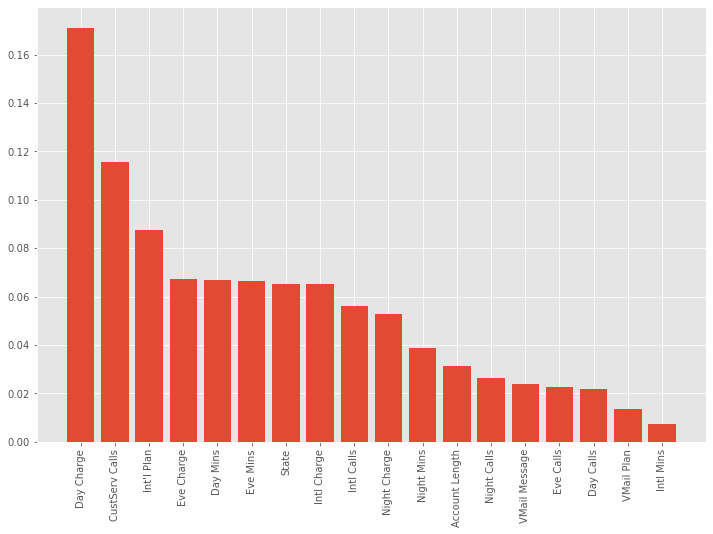

In [16]:
ind_dt,new_import_df_dt=get_importance(importance_dt)
plt.bar([x for x in range(len(new_import_df_dt))], new_import_df_dt[0])
plt.xticks([i for i in range(len(ind_dt))],ind_dt,rotation=90)
plt.show()

# Building model using Naive Bayes

### Training the Naive Bayes Classification model on the Training set

In [17]:
def naive_bayes_class():
    classifier = GaussianNB()
    classifier.fit(X_train, y_train)
    return classifier

In [18]:
nb_class=naive_bayes_class()

In [ ]:
explainer_nb_all = ClassifierExplainer(nb_class, X_test, y_test, 
                                descriptions=feature_descriptions,
                                labels=['Not Churn', 'Churn'], 
                                cats=['State'],
                                idxs = phone_numbers, 
                                index_name = "Phone Number", 
                                target = "Churn", 
                                )
db_nb_all=ExplainerDashboard(explainer_nb_all, 
                        title="Churn Prediction by Naive Bayes", 
                        shap_interaction=False,
                        )
db_nb_all.run(port=8050)

### Making the Confusion Matrix for Naive Bayes

In [19]:
cm_scores(nb_class)

[[424 295]
 [ 49  66]]
 
True Positive is 66.
True Negative is 424.
False Positive is 295.
False Negative is 49.

Accuracy is 0.59.
Recall is 0.57.
Precision is 0.18.



### Visualize the importances of attributes

In [20]:
from sklearn.inspection import permutation_importance

In [21]:
imps = permutation_importance(nb_class, X_test, y_test)
importance_nb=imps.importances_mean

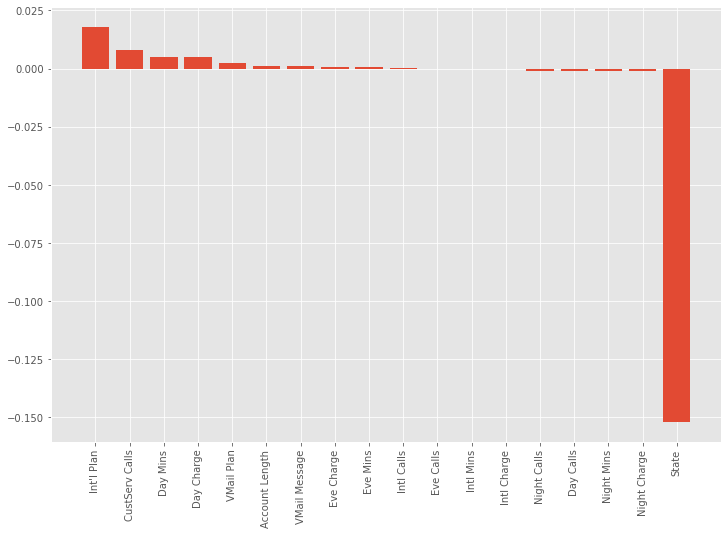

In [22]:
ind_nb,new_import_df_nb=get_importance(importance_nb)
plt.bar([x for x in range(len(new_import_df_nb))], new_import_df_nb[0])
plt.xticks([i for i in range(len(ind_nb))],ind_nb,rotation=90)
plt.show()